In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

import rpy2
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [2]:
# pd.set_option("display.max_columns", None)

In [3]:
NSCLC_sc = sc.read_h5ad("./NSCLC_sc/scRNA.h5ad")


In [4]:
cosmx_sc = sc.read_h5ad("./sc_lung_5_1.h5ad")

In [5]:
# genes from two datasets
genes1 = set(NSCLC_sc.var_names)
genes2 = set(cosmx_sc.var_names)

# common genes
common_genes = genes1.intersection(genes2)

NSCLC_sc = NSCLC_sc[:, NSCLC_sc.var_names.isin(common_genes)]
cosmx_sc = cosmx_sc[:, cosmx_sc.var_names.isin(common_genes)]

In [6]:
# NSCLC_sc, cosmx_sc
cosmx_sc = cosmx_sc[:10000]

In [150]:
cosmx_sc.obs['cell_type'].value_counts()

tumor           2255
endothelial     1081
fibroblast      1071
neutrophil       865
T CD4 naive      702
B-cell           688
epithelial       662
macrophage       610
plasmablast      578
mDC              339
pDC              292
mast             273
T CD8 naive      230
NK               185
T CD4 memory      75
monocyte          63
Treg              24
T CD8 memory       7
Name: cell_type, dtype: int64

In [151]:
NSCLC_sc.obs['celltype_final'].value_counts()

T_cells            2507
Mac_Mono           2398
Fibroblast         1603
Plasma              634
Endothelial         620
DCs                 487
Alveolar_type_2     476
B_cells             358
Mast                350
Neutrophils         344
Alveolar_type_1     115
Club_cells           89
Ciliated_cells       19
Name: celltype_final, dtype: int64

In [277]:
chosen_celltype_sc = "B_cells"
# chosen_celltype_cosmx = ["T CD8 naive", "T CD4 naive", "T CD8 memory", "T CD4 memory", "Treg"]
# chosen_celltype_cosmx = ["mDC", "mDC"]
chosen_celltype_cosmx = "B-cell"

# cosmx_sc_chosen = cosmx_sc[cosmx_sc.obs['cell_type'].isin(chosen_celltype_cosmx)]
cosmx_sc_chosen = cosmx_sc[cosmx_sc.obs['cell_type'] == chosen_celltype_cosmx]
sc_nsclc_chosen = NSCLC_sc[NSCLC_sc.obs['celltype_final'] == chosen_celltype_sc]


In [278]:
cosmx_sc_chosen, sc_nsclc_chosen

(View of AnnData object with n_obs × n_vars = 688 × 942
     obs: 'cell_ID', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.CD298', 'Max.CD298', 'Mean.G', 'Max.G', 'Mean.Y', 'Max.Y', 'Mean.R', 'Max.R', 'Mean.DAPI', 'Max.DAPI', 'dualfiles', 'Slide_name', 'tissue', 'Run_name', 'ISH.concentration', 'Dash', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'log10totalcounts', 'background', 'remove_flagged_cells', 'patient', 'cell_type', 'niche', 'prop_tumor_in_100_neighbors',
 View of AnnData object with n_obs × n_vars = 358 × 942
     obs: 'celltype_final'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
     uns: 'celltype_mapper', 'neighbors'
     obsm: 'X_pca', 'X_tsne'
     varm: 'PCs'
     layers: 'norm')

In [279]:
sc_nsclc_chosen.obs_names, cosmx_sc_chosen.obs_names

(Index(['J21_B000883', 'K1_B003776', 'I15_B003115', 'M13_B001559', 'H8_B003179',
        'D10_B003643', 'L20_B001559', 'O20_B003115', 'O19_B001551',
        'I2_B003117',
        ...
        'O18_B001474', 'N6_B003775', 'M21_B003777', 'H13_B003117', 'G7_B003117',
        'J2_B000280', 'H14_B001559', 'B2_B003777', 'A1_B003103', 'A13_B003117'],
       dtype='object', length=358),
 Index(['25', '44', '51', '52', '110', '115', '125', '192', '198', '219',
        ...
        '9941', '9946', '9947', '9948', '9959', '9974', '9976', '9980', '9988',
        '9996'],
       dtype='object', length=688))

In [280]:
cosmx_sc_chosen_list = ['1'] * len(cosmx_sc_chosen.obs_names) + ['0'] * len(sc_nsclc_chosen.obs_names)
sc_nsclc_chosen_list = ['0'] * len(cosmx_sc_chosen.obs_names) + ['1'] * len(sc_nsclc_chosen.obs_names)
index_list = list(cosmx_sc_chosen.obs_names) + list(sc_nsclc_chosen.obs_names)
design = pd.DataFrame({'cosmx': cosmx_sc_chosen_list, 'sc': sc_nsclc_chosen_list}, index=index_list)
design = design.applymap(lambda x: int(x))


sc_nsclc_chosen_df = pd.DataFrame(sc_nsclc_chosen.X.todense(), index=sc_nsclc_chosen.obs_names, columns=sc_nsclc_chosen.var_names)
cosmx_sc_chosen_df = pd.DataFrame(cosmx_sc_chosen.X, index=cosmx_sc_chosen.obs_names, columns=cosmx_sc_chosen.var_names)

# # concat two dataframe
exp = pd.concat([cosmx_sc_chosen_df, sc_nsclc_chosen_df], axis=0).T

In [281]:
limma = importr('limma')
edgeR = importr('edgeR')
contrast_matrix = limma.makeContrasts(
    'cosmx-sc', levels=design
)

exp_r = pandas2ri.py2rpy(exp)
design = pandas2ri.py2rpy(design)
from rpy2.robjects import globalenv
globalenv['exp_r']=exp_r
globalenv['design']=design
rscript='''
contrasts_matrix<-makeContrasts("cosmx-sc",levels=design)

v <- voom(exp_r,design,normalize="quantile")
fit<-lmFit(v,design)
fit2<-contrasts.fit(fit,contrasts_matrix)
fit2<-eBayes(fit2)
temp<-topTable(fit2,coef=1,n=Inf)
nrDEG=na.omit(temp)
'''
r(rscript)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
MZT2A,7.499582,13.763856,120.798322,0.000000e+00,0.000000e+00,1373.514158
DUSP5,6.288537,12.857391,64.652993,0.000000e+00,0.000000e+00,825.367274
TYK2,4.971344,12.425936,27.743162,1.864051e-127,5.853121e-125,279.765539
B2M,-3.606692,14.123389,-13.484599,2.483807e-38,5.849365e-36,76.209486
CD74,-1.691179,15.258493,-12.694650,1.889709e-34,3.560212e-32,67.379048
...,...,...,...,...,...,...
ADORA2A,-0.000306,8.387957,-0.001745,9.986077e-01,9.996689e-01,-7.429280
EOMES,-0.006423,8.331778,-0.063991,9.489896e-01,9.737998e-01,-7.429343
IFNG,-0.002378,8.362695,-0.015417,9.877025e-01,9.912287e-01,-7.430042
CCL28,0.005922,8.362629,0.037159,9.703652e-01,9.843757e-01,-7.430047


In [282]:
result=r(rscript)   
fold_cutoff=1 # logFC threshold
adjp_cutoff=0.05 # adjusted p-value threshold
 
list3=[]   
normal_list=[]  
for j in range(0,len(result.index)):
    if (abs(result['logFC'][j])>=fold_cutoff) and (result['adj.P.Val'][j]<=adjp_cutoff):
        list3.append(j)
    else:
        normal_list.append(result.index.tolist()[j])
print("the number of DE genes:",len(list3))
print("the number of normal genes:",len(normal_list))

the number of DE genes: 54
the number of normal genes: 888


In [283]:
up_list=[]   # up-reguated gene id list
for h1 in range(0,len(result.index)):
    if (result['logFC'][h1]>=fold_cutoff) and (result['adj.P.Val'][h1]<=adjp_cutoff):
        up_list.append(result.index.tolist()[h1])
down_list=[]  # down-regulated gene id list
for h2 in range(0,len(result.index)):
    if (result['logFC'][h2]<-(fold_cutoff)) and (result['adj.P.Val'][h2]<=adjp_cutoff):
        down_list.append(result.index.tolist()[h2])
print("the number of up-regulated genes:",len(up_list))
print("the number of down-regulated genes",len(down_list))
print("the number of differentially expressed genes:",len(up_list)+len(down_list))
DEG_up=exp[exp.index.isin(up_list)]
DEG_down=exp[exp.index.isin(down_list)]
print("the dimsension of up-regulated genes:",DEG_up.shape)
print("the dimsension of down-regulated genes",DEG_down.shape)
DEG_up['up/down']=['up']*len(DEG_up) 
DEG_down['up/down']=['down']*len(DEG_down) 
DEG_matrix=pd.concat([DEG_up,DEG_down],join='inner')   
# DEG_matrix
# DEG_matrix.to_excel("Lung.xlsx",index=True)   

the number of up-regulated genes: 5
the number of down-regulated genes 49
the number of differentially expressed genes: 54
the dimsension of up-regulated genes: (5, 1046)
the dimsension of down-regulated genes (49, 1046)


In [284]:
result['adj.P.Val_log']=-np.log10(result['adj.P.Val'])   # -log10(adj p-value)
result['sig']='normal'    # set all genes as normal
result.loc[(result['logFC']>=1)&(result['adj.P.Val']<0.05),'sig']='up'   # up regulated genes 
result.loc[(result['logFC']<-1)&(result['adj.P.Val']<0.05),'sig']='down'  # down regulated genes
result

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
MZT2A,7.499582,13.763856,120.798322,0.000000e+00,0.000000e+00,1373.514158,inf,up
DUSP5,6.288537,12.857391,64.652993,0.000000e+00,0.000000e+00,825.367274,inf,up
TYK2,4.971344,12.425936,27.743162,1.864051e-127,5.853121e-125,279.765539,124.232613,up
B2M,-3.606692,14.123389,-13.484599,2.483807e-38,5.849365e-36,76.209486,35.232891,down
CD74,-1.691179,15.258493,-12.694650,1.889709e-34,3.560212e-32,67.379048,31.448524,down
...,...,...,...,...,...,...,...,...
ADORA2A,-0.000306,8.387957,-0.001745,9.986077e-01,9.996689e-01,-7.429280,0.000144,normal
EOMES,-0.006423,8.331778,-0.063991,9.489896e-01,9.737998e-01,-7.429343,0.011530,normal
IFNG,-0.002378,8.362695,-0.015417,9.877025e-01,9.912287e-01,-7.430042,0.003826,normal
CCL28,0.005922,8.362629,0.037159,9.703652e-01,9.843757e-01,-7.430047,0.006839,normal


In [285]:
DEG_result = result[result["sig"] != 'normal']
DEG_result

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
MZT2A,7.499582,13.763856,120.798322,0.000000e+00,0.000000e+00,1373.514158,inf,up
DUSP5,6.288537,12.857391,64.652993,0.000000e+00,0.000000e+00,825.367274,inf,up
TYK2,4.971344,12.425936,27.743162,1.864051e-127,5.853121e-125,279.765539,124.232613,up
B2M,-3.606692,14.123389,-13.484599,2.483807e-38,5.849365e-36,76.209486,35.232891,down
CD74,-1.691179,15.258493,-12.694650,1.889709e-34,3.560212e-32,67.379048,31.448524,down
CALM1,-3.770564,9.819680,-11.965557,5.100581e-31,8.007913e-29,59.522605,28.096481,down
HLA-B,-2.443929,14.174669,-10.229620,1.777417e-23,2.391895e-21,42.401872,20.621258,down
HLA-DRB1,-2.813598,13.064932,-8.032669,2.551921e-15,3.004887e-13,23.875589,12.522172,down
HLA-A,-2.475760,13.266498,-7.793290,1.567162e-14,1.503417e-12,22.101256,11.822921,down
JUNB,-3.963796,10.318537,-7.655383,4.364225e-14,3.737364e-12,21.068616,11.427435,down


In [286]:
DEG_up = result[result["sig"] == "up"]
DEG_up_6 = DEG_up.head(6)
# DEG_down = DEG_result[DEG_result["sig"] == "down"]
# DEG_down = DEG_down.head(6)

In [287]:
DEG_up_6

,logFC,AveExpr,t,P.Value,adj.P.Val,B,adj.P.Val_log,sig
MZT2A,7.499582,13.763856,120.798322,0.000000e+00,0.000000e+00,1373.514158,inf,up
DUSP5,6.288537,12.857391,64.652993,0.000000e+00,0.000000e+00,825.367274,inf,up
TYK2,4.971344,12.425936,27.743162,1.864051e-127,5.853121e-125,279.765539,124.232613,up
COL9A2,2.819904,10.447927,4.833676,1.540563e-06,5.004173e-05,4.101122,4.300668,up
NPPC,2.616774,10.259041,4.162721,3.403005e-05,8.904528e-04,1.142392,3.050389,up


In [288]:
data_plotter = []
for gene in DEG_up_6.index:
    data_plotter.append(np.log1p(cosmx_sc_chosen_df[gene].values))
    data_plotter.append(np.log1p(sc_nsclc_chosen_df[gene].values))

    
# data_plotter = []
# for gene in DEG_up_6.index:
#     data_plotter.append(cosmx_sc_chosen_df[gene].values)
#     data_plotter.append(sc_nsclc_chosen_df[gene].values)


In [289]:
chosen_celltype_cosmx

'B-cell'

In [290]:
chosen_celltype_cosmx = "B Cells"

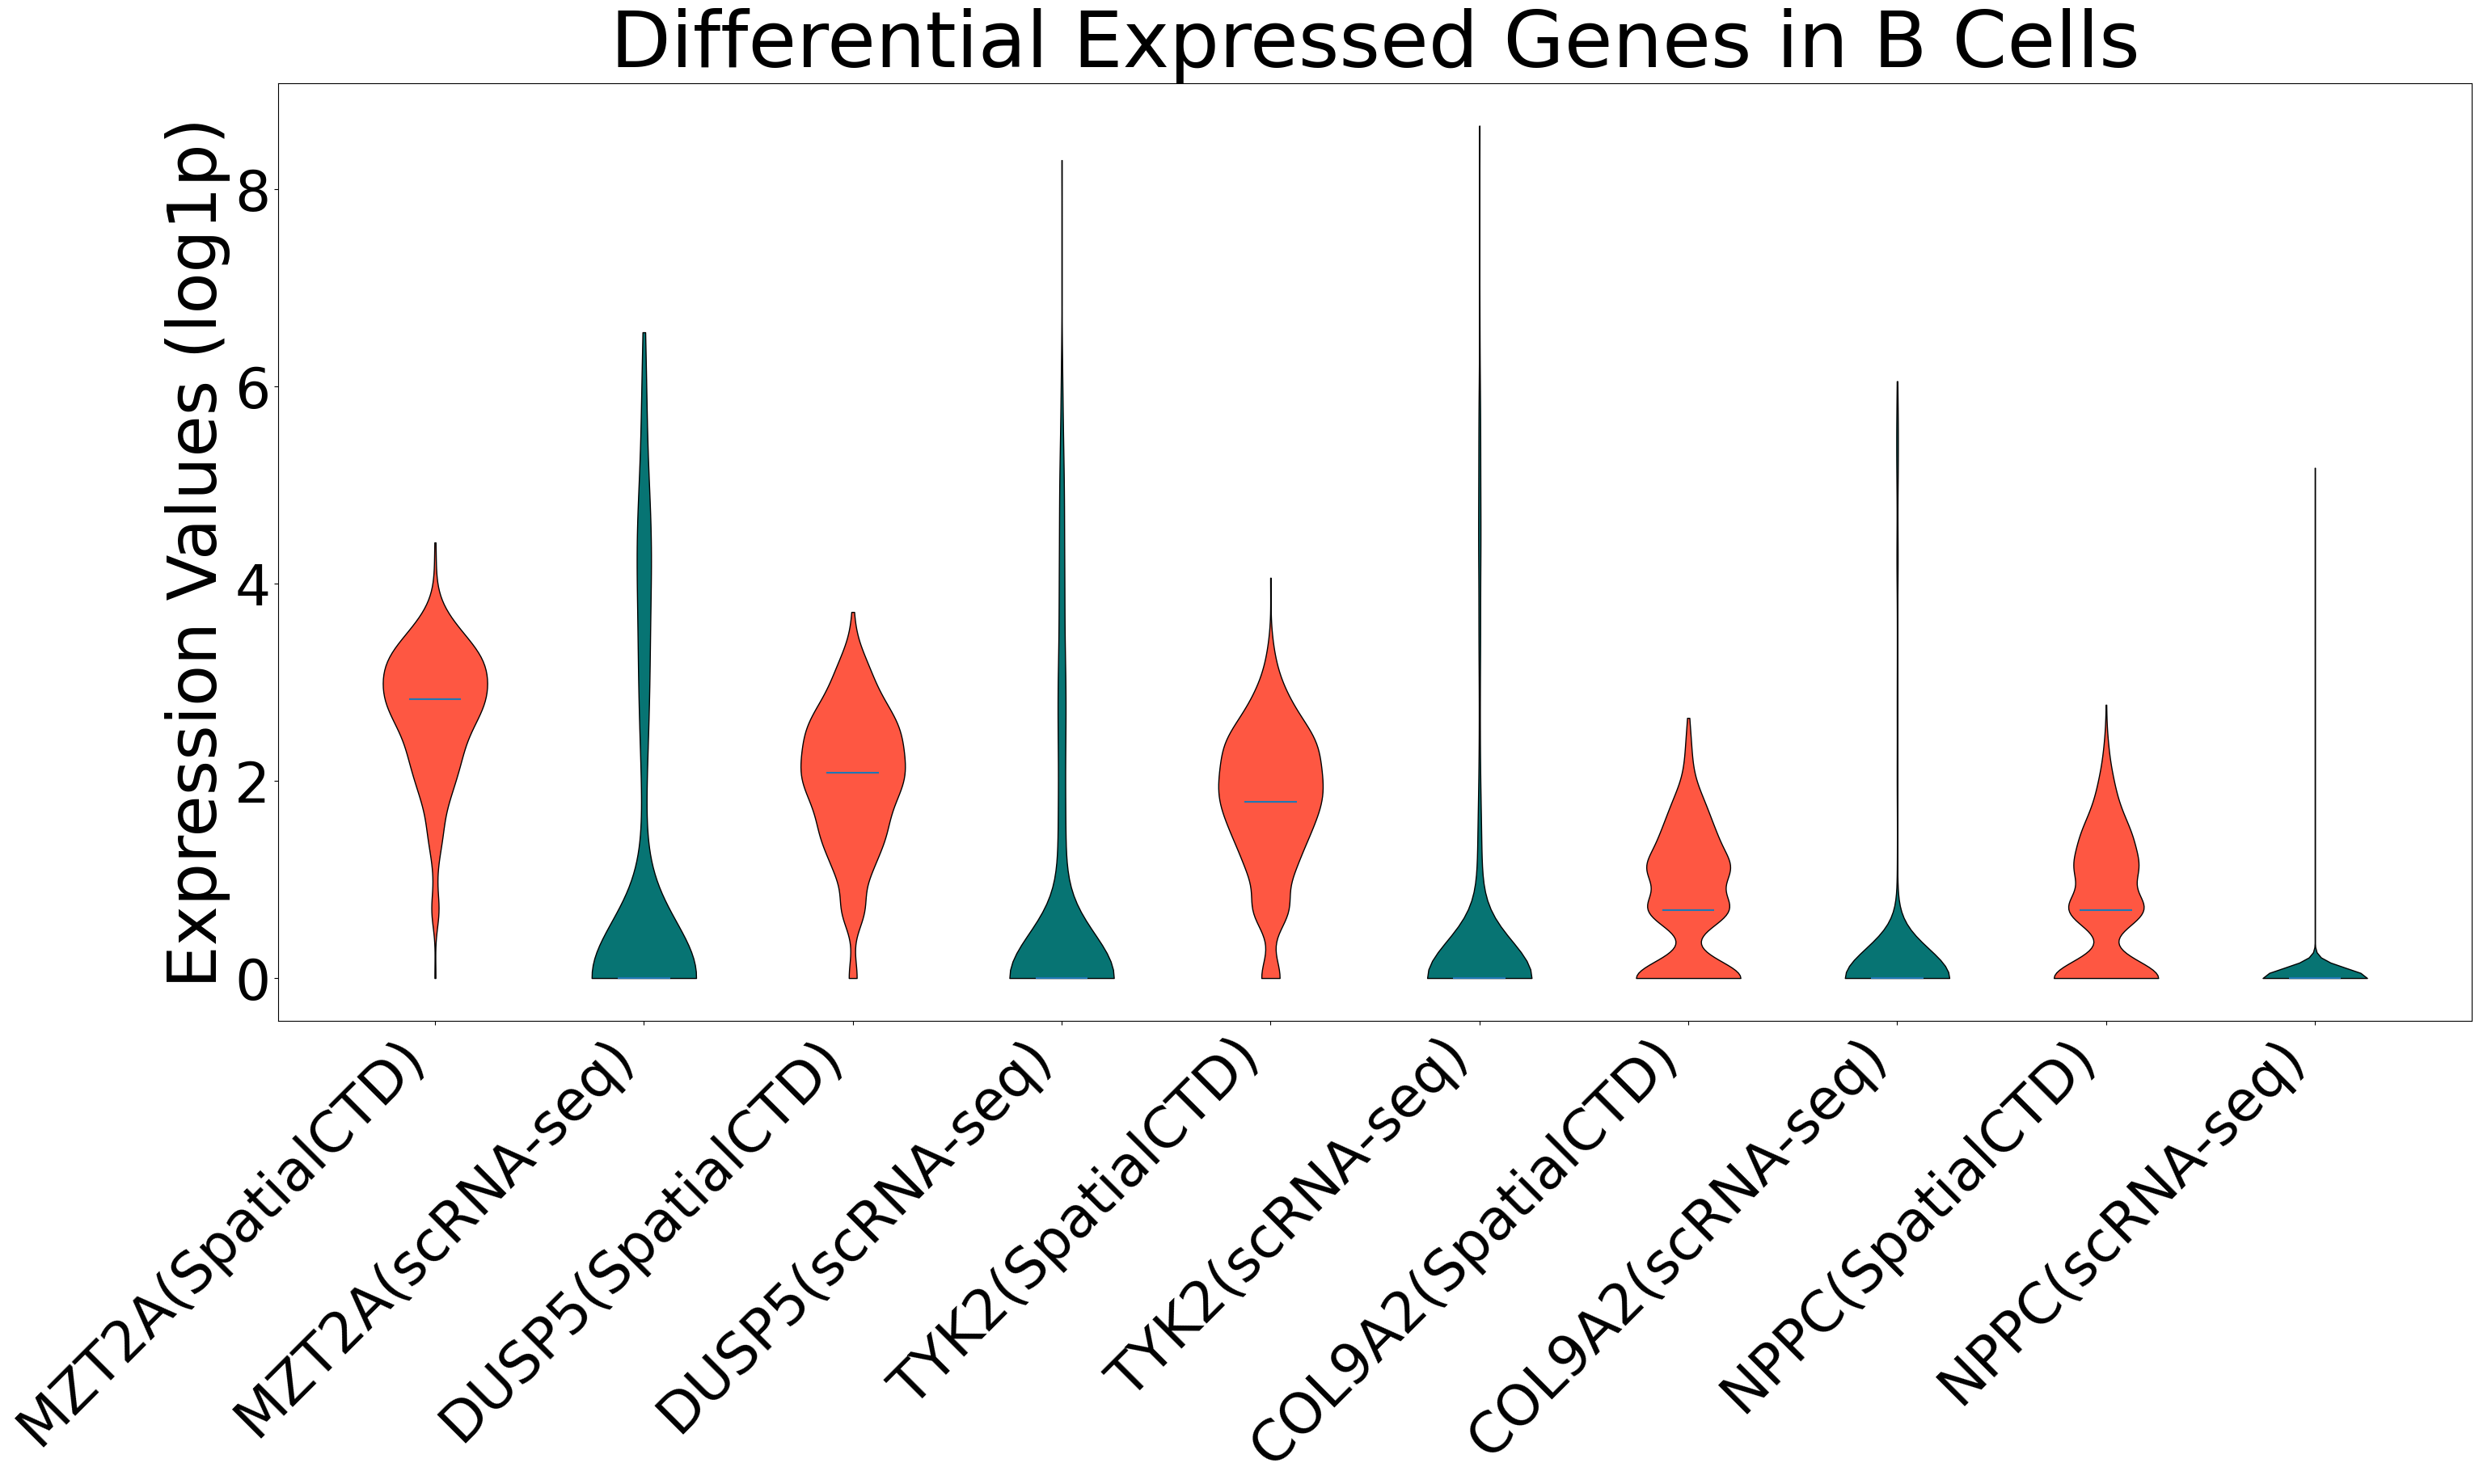

In [291]:
import matplotlib.pyplot as plt
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation = 45, fontsize = 50,  ha='right')
    ax.set_xlim(0.25, len(labels) + 0.75)
    # ax.set_ylabel('Y Axis', fontsize=14)
    # ax.set_yticks(fontsize = 10)
    ax.tick_params(axis='y', labelsize=50)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 20), sharey=True)
ax.set_ylabel("Expression Values (log1p)", fontsize= 60)
ax.set_title("Differential Expressed Genes in %s"%(chosen_celltype_cosmx), fontsize= 70)
parts = ax.violinplot(
    data_plotter, showmeans=False, showmedians=True,
    showextrema=False
)
for i in range(len(parts['bodies'])):
    if i % 2 == 0:
        parts['bodies'][i].set_facecolor('#fe5742') 
    else:
        parts['bodies'][i].set_facecolor('#077473') 
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)
labels = []
for gene in DEG_up_6.index:
    labels.append(gene+str("(SpatialCTD)"))
    labels.append(gene+str("(scRNA-seq)"))



set_axis_style(ax, labels)
plt.subplots_adjust(bottom=0.30, wspace=0.05)
plt.savefig("./fig/%s_up.pdf"%(chosen_celltype_cosmx))
plt.show()